<a href="https://colab.research.google.com/github/SupriyaRani/Multimodal-Fusion-on-AVSD/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pickle
import logging
import numpy as np
import torch
import torch.utils.data
from torch.utils.data import Dataset
from itertools import chain
import tarfile
from argparse import ArgumentParser
#from utils.meta.dataset import get_dataset, build_input_from_segments
#from utils.meta.VideoGPT2 import *
#from utils.meta.train import SPECIAL_TOKENS, SPECIAL_TOKENS_DICT
#!pip install tensorflow --upgrade --force-reinstall
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Concatenate
from tensorflow.keras.models import Model

In [2]:
import pandas as pd
import json
from pandas import json_normalize
import re
path = '../data/annotations/train_set4DSTC7-AVSD.json'
text_data = json.load(open(path,'r'))
text_data = json_normalize(text_data['dialogs']) 
text_data = text_data.explode('dialog').reset_index(drop=True)
text_data = text_data.join(pd.json_normalize(text_data.dialog)).drop(columns=['dialog'])
text_data.head()


,image_id,summary,caption,answer,question
0,7UPGT,a woman goes to a fridge opens the door gets a...,a person standing in the kitchen is looking th...,yes ahe is already in the room,is the woman already in the room ?
1,7UPGT,a woman goes to a fridge opens the door gets a...,a person standing in the kitchen is looking th...,no other peiple in the video,is there any other people ?
2,7UPGT,a woman goes to a fridge opens the door gets a...,a person standing in the kitchen is looking th...,no she isnt talking in this video,is she talking in the video ?
3,7UPGT,a woman goes to a fridge opens the door gets a...,a person standing in the kitchen is looking th...,no music is heard there,is there any music heard ?
4,7UPGT,a woman goes to a fridge opens the door gets a...,a person standing in the kitchen is looking th...,she takes a cup from the fridge but didnt drink,does the woman eat or drink anything ?


In [3]:
img_list = list(text_data['image_id']+'.npy')

In [4]:
len(img_list)

76590

In [5]:
# my_tar = tarfile.open('../data/data.tar')
# my_tar.extractall('./data/data_new') # specify which folder to extract to
# my_tar.close()

In [6]:
# 1st i3d flow
path = '../data/dataset/i3d_flow_100/i3d_flow/'
i3d_flow = []
img_lst = []
for i in os.listdir(path):
  if i in img_list:
    img_lst.append(i)
    data = np.load(path+i)
    i3d_flow.append(data)
print('Length = ', len(img_lst))
#np.save('./data/dataset/i3d_flow.npy', i3d_flow)    # .npy extension is added if not given
#d = np.load('test3.npy')

Length =  7659


In [7]:
# 2nd i3d_rgb_vgg19_4
path = './data/data_new/i3d_rgb_vgg19_4/'
i3d_rgb = []
img_lst = []
for i in os.listdir(path):
  if i in img_list:
    img_lst.append(i)
    data = np.load(path+i)
    i3d_rgb.append(data)
print('Length = ', len(img_lst))
#np.save('./data/dataset/i3d_rgb.npy', i3d_rgb)    # .npy extension is added if not given
#d = np.load('test3.npy')

Length =  7659


In [8]:
# 3rd vggish
path = './data/data_new/vggish/'
vggish = []
img_lst = []
for i in os.listdir(path):
  if i in img_list:
    img_lst.append(i)
    data = np.load(path+i)
    vggish.append(data)
print('Length = ', len(img_lst))
#np.save('./data/dataset/vggish.npy', vggish)    # .npy extension is added if not given
#d = np.load('test3.npy')

Length =  7659


In [9]:
text_data.shape

(76590, 5)

In [10]:
text_data['image_id'].value_counts()

7UPGT    10
AMUDT    10
5Q6N6    10
SQKR0    10
13AUQ    10
         ..
Z5KH4    10
06R14    10
RS3SQ    10
WWNVG    10
W25MK    10
Name: image_id, Length: 7659, dtype: int64

In [11]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76590 entries, 0 to 76589
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  76590 non-null  object
 1   summary   76590 non-null  object
 2   caption   76590 non-null  object
 3   answer    76590 non-null  object
 4   question  76590 non-null  object
dtypes: object(5)
memory usage: 2.9+ MB


In [12]:
text_data.isnull().sum()

image_id    0
summary     0
caption     0
answer      0
question    0
dtype: int64

In [13]:
#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing import text, sequence


In [14]:
# Removing Punctuations
text_data['question']=text_data['question'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
text_data['answer']=text_data['answer'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
text_data['summary']=text_data['summary'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Removing extra spaces
text_data['question']=text_data['question'].apply(lambda x: re.sub(' +',' ',x))
text_data['answer']=text_data['answer'].apply(lambda x: re.sub(' +',' ',x))
text_data['summary']=text_data['summary'].apply(lambda x: re.sub(' +',' ',x))

In [15]:
for index,text in enumerate(text_data['question'][35:40]):
    print('summary %d:\n'%(index+1),text)

summary 1:
 can you see him add anything to that boiling water 
summary 2:
 does he eat or drink anything in this video 
summary 3:
 does he say anything or make any sounds 
summary 4:
 does he do anything else that i don t know about 
summary 5:
 does he seem to be in a hurry 


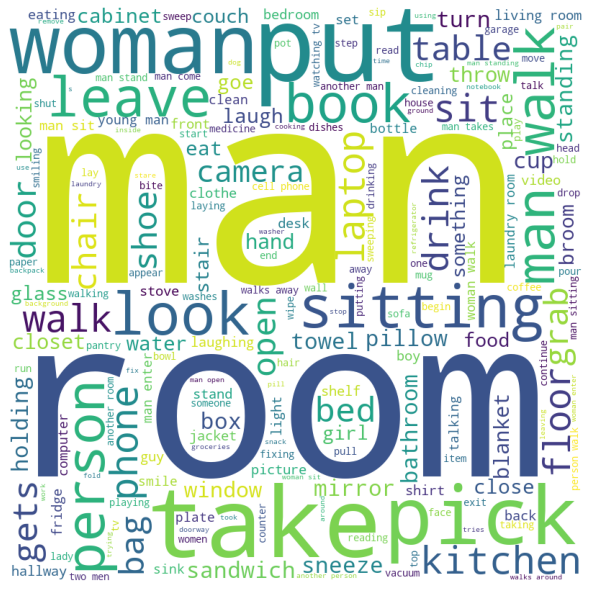

In [16]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
# Reads 'Youtube04-Eminem.csv' file
df = text_data
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df['summary']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [17]:
#my_tar = tarfile.open('./data/annotations.tar')
#my_tar.extractall('./data/annotations') # specify which folder to extract to
#my_tar.close()

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [19]:
# natural language processing: n-gram ranking
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
ADDITIONAL_STOPWORDS = ['covfefe']

import matplotlib.pyplot as plt
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


words = basic_clean(''.join(str(df['question'].tolist())))

Text(0.5, 0, '# of Occurances')

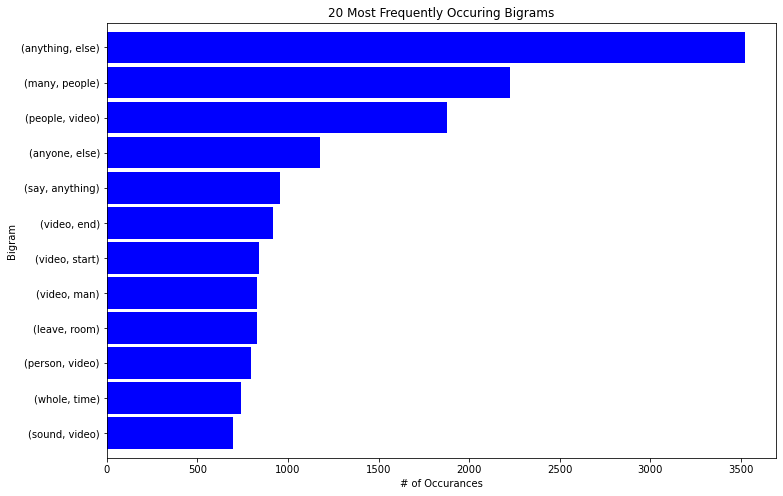

In [20]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:12]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:12]
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

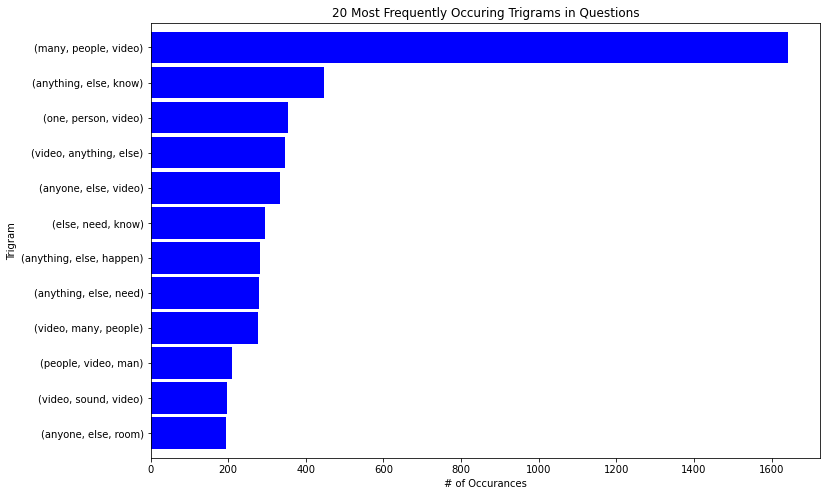

In [21]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams in Questions')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

In [22]:
#import urllib.request
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

In [23]:
#!unzip "/data/glove.6B.zip" -d "./data/"

In [24]:
#!pip install -q -U "tensorflow-text==2.8.*"
#!pip install -q tf-models-official==2.4.0

In [25]:
questions =text_data.question.str.lower().tolist()
summary =text_data.summary.str.lower().tolist()
dialogues =text_data.caption.str.lower().tolist()
answer = text_data.answer.str.lower().tolist()

In [26]:
df = text_data

In [27]:
%%time
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['summary_cleaned'] = df['summary'].apply(lambda txt: clean_text(txt))


Wall time: 40.3 s


In [28]:
X = df.drop('answer', axis = 1)
y = df['answer']

#split data in test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [29]:
y_train

75016                  he only has one rag that i can see 
38084                          it sounds like techno music
56750    yes he is standing at the closet in the beginn...
56417    after he picks up the books he opens a shelf a...
43923    she grabs honey out of the pantry and puts int...
                               ...                        
23315    he lifts the flaps of cardboard and then leans...
40341            no the man is alone throughout the video 
28250            one there is only one person in the room 
31244    no she sits on sofa with food packet and grabs...
61103    she puts the broom down and then walks out of ...
Name: answer, Length: 61272, dtype: object

In [30]:
# find the length of the largest sentence in training data
L_s = x_train['summary'].apply(lambda x: len(x)).max()
L_s

546

In [31]:
# find the length of the largest sentence in training data
max_len = x_train.apply(lambda x: len(x)).max()
max_len

61272

In [32]:
max_words = 10000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(x_train)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(x_train)
xtest_seq = tokenizer.texts_to_sequences(x_test)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

#print('text example:', x_train)
print('sequence of indices(before padding):', xtrain_seq[0])
print('sequence of indices(after padding):', xtrain_pad[0])

sequence of indices(before padding): [2, 3]
sequence of indices(after padding): [0 0 0 ... 0 2 3]


In [33]:
%%time
embedding_vectors = {}
with open('../data/glove/glove.6B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   


Size of vocabulary in GloVe: 400000
Wall time: 57.3 s


In [34]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: []


# Encoder

In [35]:
#from keras.models import Sequential
#from keras.layers import Input,Dense, Embedding, GRU, Dropout, Bidirectional, SpatialDropout1D
import keras

max_features = 1000
GRU_DIM = 1
max_len = 7330
q = keras.layers.Input(shape=(max_len,), name='questions')
q1 = tf.expand_dims(q,axis=2, name = 'q_expan')

BiGRU_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True), name = 'bigru_q1')(q1)
BiGRU_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True), name = 'bigru_q2')(BiGRU_1)
BiGRU_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True), name = 'bigru_q3')(BiGRU_2)

q_bar = tf.expand_dims(BiGRU_3,axis=0, name = 'qbar-expan')

m_q = keras.layers.Conv2D(1, (1,1), activation='ReLU')(q_bar)
m_q = keras.layers.Conv2D(2, (1,1), activation='ReLU')(m_q)

Q = tf.keras.layers.Attention(causal=True, score_mode='dot')([q_bar, m_q])
Q = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len*2), trainable=False)(Q)
Q = keras.layers.Dense(1, activation='ReLU')(Q)

Q = tf.keras.layers.Reshape(target_shape=(max_len*2,), input_shape=(max_len,))(Q)
print(q)
print(Q)
# initialize the model
model_q = keras.models.Model(inputs=q, outputs=Q)
    
#model_q.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_q.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 7330), dtype=tf.float32, name='questions'), name='questions', description="created by layer 'questions'")
KerasTensor(type_spec=TensorSpec(shape=(1, 14660), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 questions (InputLayer)         [(None, 7330)]       0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 7330, 1)      0           ['questions[0][0]']              
                                                                                                  
 bigru_q1 (Bidirectional)       (None, 7330, 6)      108         ['tf.expand_dims[0][0]'] 

In [36]:
for i, layer in enumerate(model_q.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 questions [(None, 7330)] True
1 tf.expand_dims (None, 7330, 1) True
2 bigru_q1 (None, 7330, 6) True
3 bigru_q2 (None, 7330, 4) True
4 bigru_q3 (None, 7330, 2) True
5 tf.expand_dims_1 (1, None, 7330, 2) True
6 conv2d (1, None, 7330, 1) True
7 conv2d_1 (1, None, 7330, 2) True
8 attention (1, None, 7330, 2) True
9 embedding (1, None, 7330, 2, 14660) False
10 dense (1, None, 7330, 2, 1) True
11 reshape (1, 14660) True


In [37]:
q_bar = model_q.get_layer('bigru_q3').output

In [38]:
#q_bar = BiGRU_3
q_bar_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_qbar")(q_bar)
print(q_bar_t)

KerasTensor(type_spec=TensorSpec(shape=(None, 7330, 2), dtype=tf.float32, name=None), name='transpose_qbar/transpose:0', description="created by layer 'transpose_qbar'")


In [39]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, Concatenate, Lambda
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.backend import cast
from keras.models import Model

In [40]:
#summary

max_features = 1000
GRU_DIM = 1
s = Input(shape=(max_len,max_features,), name='summary')

BiGRU_s_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True), name = 'bigru_s1')(s)
BiGRU_s_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True), name = 'bigru_s2')(BiGRU_s_1)
BiGRU_s_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=False), name = 'bigru_s3')(BiGRU_s_2)

m_s = tf.keras.layers.Attention(causal=False, score_mode = 'dot', name = 'attn_s')([ BiGRU_s_3,q_bar_t])

m_s = tf.keras.activations.softmax(m_s, axis=-1)
m_s_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_s")(m_s)

m_s_relu = tf.keras.activations.relu([m_s_t,q_bar],1)
S = tf.keras.layers.MaxPooling2D((1,1), padding='same')(m_s_relu)

S = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len*2), trainable=False)(S)
S = tf.keras.layers.Reshape(target_shape=(max_len*2,max_len*2))(S)
S = tf.keras.layers.Resizing(width=1,height=1)(S)
S = tf.keras.layers.Reshape(target_shape=(max_len*2,))(S)
# initialize the model
model_s = Model(inputs=[s,q], outputs=S)
  
#model_s.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_s.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 questions (InputLayer)         [(None, 7330)]       0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 7330, 1)      0           ['questions[0][0]']              
                                                                                                  
 summary (InputLayer)           [(None, 7330, 1000)  0           []                               
                                ]                                                                 
                                                                                                  
 bigru_q1 (Bidirectional)       (None, 7330, 6)      108         ['tf.expand_dims[0][0]']   

In [41]:
for i, layer in enumerate(model_s.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 questions [(None, 7330)] True
1 tf.expand_dims (None, 7330, 1) True
2 summary [(None, 7330, 1000)] True
3 bigru_q1 (None, 7330, 6) True
4 bigru_s1 (None, 7330, 6) True
5 bigru_q2 (None, 7330, 4) True
6 bigru_s2 (None, 7330, 4) True
7 bigru_q3 (None, 7330, 2) True
8 bigru_s3 (None, 2) True
9 transpose_qbar (None, 7330, 2) True
10 attn_s (None, None, 2) True
11 tf.nn.softmax (None, None, 2) True
12 transpose_s (None, None, 2) True
13 tf.nn.leaky_relu (2, None, 7330, 2) True
14 max_pooling2d (2, None, 7330, 2) True
15 embedding_1 (2, None, 7330, 2, 14660) False
16 reshape_1 (2, 14660, 14660) True
17 resizing (1, 1, 14660) True
18 reshape_2 (1, 14660) True


In [47]:
#Dialogue

max_features = 1000
GRU_DIM = 1
d = Input(shape=(max_len,max_features,), name='dialogues')

BiGRU_d_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True), name = 'bigru_d1')(d)
BiGRU_d_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True), name = 'bigru_d2')(BiGRU_d_1)
BiGRU_d_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True), name = 'bigru_d3')(BiGRU_d_2)

m_s = tf.keras.layers.Attention(causal=False, score_mode = 'dot', name = 'attn_d')([ BiGRU_d_3,q_bar_t])

m_s = tf.keras.activations.softmax(m_s, axis=-1)
m_s_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_d")(m_s)

m_s_relu = tf.keras.activations.relu([m_s_t,q_bar],1)
D = tf.keras.layers.MaxPooling2D((1,1), padding='same')(m_s_relu)

D = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len), trainable=False)(D)
D = tf.keras.layers.Reshape(target_shape=(max_len*2,max_len*2))(D)
D = tf.keras.layers.Resizing(width=1,height=1)(D)
D = tf.keras.layers.Reshape(target_shape=(max_len*2,))(D)
# initialize the model
model_d = Model(inputs=[d,q], outputs=D)
  
#model_d.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_d.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[7330,7330] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [ ]:
for i, layer in enumerate(model_d.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 questions [(None, 7330)] True
1 tf.expand_dims (None, 7330, 1) True
2 dialogues [(None, 7330, 1000)] True
3 bigru_q1 (None, 7330, 6) True
4 bigru_d1 (None, 7330, 6) True
5 bigru_q2 (None, 7330, 4) True
6 bigru_d2 (None, 7330, 4) True
7 bigru_q3 (None, 7330, 2) True
8 bigru_d3 (None, 7330, 2) True
9 transpose_qbar (None, 7330, 2) True
10 attn_d (None, 7330, 2) True
11 tf.nn.softmax_1 (None, 7330, 2) True
12 transpose_d (None, 7330, 2) True
13 tf.nn.leaky_relu_1 (2, None, 7330, 2) True
14 max_pooling2d_1 (2, None, 7330, 2) True
15 embedding_2 (2, None, 7330, 2, 7330) False
16 reshape_3 (2, 14660, 14660) True
17 resizing_1 (1, 1, 14660) True
18 reshape_4 (1, 14660) True


In [48]:
# i3d_rgb = np.load('./data/dataset/i3d_rgb.npy')
# i3d_rgb

In [49]:
# max_len_i3d_rgb = max([len(i) for i in i3d_rgb])
# max_len_i3d_rgb #49

In [50]:
#i3d-rgb- > video

max_features = 1000
GRU_DIM = 1
r = keras.layers.Input(shape=(max_len,2048,), name = 'i3d_rgb_video')

BiGRU_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True))(r)
BiGRU_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True))(BiGRU_1)
BiGRU_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True))(BiGRU_2)

m_s = tf.keras.layers.Attention(causal=True, score_mode = 'dot')([BiGRU_3, q_bar_t])

m_s_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_i3drgb")(m_s)
#m_s_t = tf.expand_dims(m_s_t,axis=0)
print(m_s_t,q_bar)
m_s_relu = tf.keras.activations.relu([m_s_t,q_bar],1)

R = tf.keras.layers.MaxPooling2D((3,3), padding='same')(m_s_relu)

R = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len*2), trainable=True)(R)

R = tf.keras.layers.Reshape(target_shape=(4888,max_len*2))(R)
R = tf.keras.layers.Resizing(width=1,height=1)(R)
R = tf.keras.layers.Reshape(target_shape=(max_len*2,))(R)

# initialize the model
model_r = keras.models.Model(inputs=[r,q], outputs=R)
    
#model_r.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_r.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7330, 2), dtype=tf.float32, name=None), name='transpose_i3drgb/transpose:0', description="created by layer 'transpose_i3drgb'") KerasTensor(type_spec=TensorSpec(shape=(None, 7330, 2), dtype=tf.float32, name=None), name='bigru_q3/concat:0', description="created by layer 'bigru_q3'")


ResourceExhaustedError: OOM when allocating tensor with shape[7330,14660] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RandomUniform]

In [ ]:
# vggish_full = np.load('./data/dataset/vggish_full.npy')
# vggish_full

# max_len_vggish_full = max([len(i) for i in vggish_full])
# max_len_vggish_full

In [ ]:
#vggish_full -> Audio fatures

max_features = 128
GRU_DIM = 1
a = keras.layers.Input(shape=(max_len,max_features,), name= 'vggish_Audio')

BiGRU_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True))(a)
BiGRU_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True))(BiGRU_1)
BiGRU_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True))(BiGRU_2)

m_s = tf.keras.layers.Attention(causal=True)([BiGRU_3, q_bar_t])

m_s_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_vggish")(m_s)
#m_s_t = tf.expand_dims(m_s_t,axis=0)
m_s_relu = tf.keras.activations.relu([m_s_t,q_bar],1)

A = tf.keras.layers.MaxPooling2D((3,3), padding='same')(m_s_relu)

A = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len*2), trainable=True)(A)

A = tf.keras.layers.Reshape(target_shape=(4888,max_len*2))(A)
A = tf.keras.layers.Resizing(width=1,height=1)(A)
A = tf.keras.layers.Reshape(target_shape=(max_len*2,))(A)

# initialize the model
model_a = keras.models.Model(inputs=[a,q], outputs=A)
    
#model_a.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_a.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 questions (InputLayer)         [(None, 7330)]       0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 7330, 1)      0           ['questions[0][0]']              
                                                                                                  
 vggish_Audio (InputLayer)      [(None, 7330, 128)]  0           []                               
                                                                                                  
 bigru_q1 (Bidirectional)       (None, 7330, 6)      108         ['tf.expand_dims_2[0][0]']       
                                                                                           

In [ ]:
import os
import numpy as np
# path = './data/dataset/i3d_flow/i3d_flow_testset/'
# i3d_flow = []
# for i in os.listdir(path):
#   data = np.load(path+i)
#   i3d_flow.append(data)

# np.save('./data/dataset/i3d_flow.npy', i3d_flow)    # .npy extension is added if not given
#d = np.load('test3.npy')

# i3d_flow = np.load('./data/dataset/i3d_flow.npy',allow_pickle=False)
# i3d_flow

# max_len_i3d_flow = max([len(i) for i in i3d_flow])
# max_len_i3d_flow

In [ ]:
#i3d_flow

max_features = 2048
GRU_DIM = 1
o = keras.layers.Input(shape=(max_len,max_features,), name = 'i3d_flow_video')

BiGRU_1 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*3, return_sequences=True))(o)
BiGRU_2 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM*2, return_sequences=True))(BiGRU_1)
BiGRU_3 = keras.layers.Bidirectional(keras.layers.GRU(GRU_DIM, return_sequences=True))(BiGRU_2)

m_s = tf.keras.layers.Attention(causal=True)([BiGRU_3, q_bar_t])

m_s_t = tf.keras.layers.Permute(dims=(1,2,), name="transpose_i3dflow")(m_s)
#m_s_t = tf.expand_dims(m_s_t,axis=0)
m_s_relu = tf.keras.activations.relu([m_s_t,q_bar],1)

O = tf.keras.layers.MaxPooling2D((3,3), padding='same')(m_s_relu)

O = keras.layers.Embedding(input_dim = (max_len), output_dim=(max_len*2), trainable=True)(O)

O = tf.keras.layers.Reshape(target_shape=(4888,max_len*2))(O)
O = tf.keras.layers.Resizing(width=1,height=1)(O)
O = tf.keras.layers.Reshape(target_shape=(max_len*2,))(O)

# initialize the model
model_o = keras.models.Model(inputs=[o,q], outputs=O)
    
#model_o.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_o.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 questions (InputLayer)         [(None, 7330)]       0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 7330, 1)      0           ['questions[0][0]']              
                                                                                                  
 i3d_flow_video (InputLayer)    [(None, 7330, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 bigru_q1 (Bidirectional)       (None, 7330, 6)      108         ['tf.expand_dims_2[0][0]']

In [ ]:
F = concatenate([O, R, A, S, D])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_target = le.fit_transform(y_train)
y_target = tf.convert_to_tensor(y_target, dtype='int32')
answers = y_target
y_target

<tf.Tensor: shape=(61272,), dtype=int32, numpy=array([50295, 37653,  2560, ..., 14323, 48230, 24040])>

In [ ]:
#max_len_y = max([(i) for i in y_target])
max_len_y = y_target.shape
max_len_y = max_len_y[0]
max_len_y

61272

In [ ]:
y_target = tf.reshape(y_target, shape=(-1,1,max_len_y,))
y_target

<tf.Tensor: shape=(1, 1, 61272), dtype=int32, numpy=array([[[50295, 37653,  2560, ..., 14323, 48230, 24040]]])>

In [ ]:
y_target = tf.keras.layers.Resizing(width=733, height=10)(y_target)
y_target.shape

TensorShape([10, 733, 61272])

In [ ]:

y_target = tf.reshape(y_target, shape=(max_len_y,1,7330,))
y_target.shape


TensorShape([61272, 1, 7330])

In [ ]:
y_target = tf.keras.layers.Resizing(width=1, height=10)(y_target)
y_target.shape

TensorShape([10, 1, 7330])

In [ ]:

y_target = tf.reshape(y_target, shape=(1,73300,))
y_target.shape


TensorShape([1, 73300])

In [ ]:
C = concatenate([F,y_target])

In [ ]:
C

<KerasTensor: shape=(1, 146600) dtype=float32 (created by layer 'concatenate_8')>

In [ ]:
tf.keras.layers.Resizing(width=1,height=1)(tf.expand_dims(C,axis=0))
#c_new = tf.expand_dims(C,axis=0)

<KerasTensor: shape=(1, 1, 146600) dtype=float32 (created by layer 'resizing_43')>

In [ ]:
c_new = tf.keras.layers.Resizing(width=1,height=1)(tf.expand_dims(C,axis=0))

In [ ]:
q_new = tf.keras.layers.Reshape(target_shape=(1,max_len,), input_shape=(max_len,))(tf.keras.layers.Resizing(width=7330,height=1)(q1))
q_new

<KerasTensor: shape=(1, 1, 7330) dtype=float32 (created by layer 'reshape_24')>

# Decoder

In [ ]:
GRU_inp = tf.keras.layers.Reshape(target_shape=(22,max_len))(concatenate([C,Q]))
GRU_inp

<KerasTensor: shape=(1, 22, 7330) dtype=float32 (created by layer 'reshape_25')>

In [ ]:
GRU1 = keras.layers.GRU(1, return_sequences=True)([GRU_inp])
#r_vec = keras.layers.RepeatVector(10)(GRU1)
## hidden layer 1
h1 = keras.layers.Dense(name="h1", units=int(round((max_len+1)/2)), activation='relu')(GRU1)
### hidden layer 2
h2 = keras.layers.Dense(name="h2", units=int(round((max_len+1)/4)), activation='relu')(h1)
### layer output
y_hat = keras.layers.Dense(name="y_hat", units=1, activation='softmax')(h2)

#GRU_whole_sequence_output, GRU_final_state


In [ ]:
model_final = Model(inputs=[q,s,d,o,r,a], outputs=[y_hat])
model_final.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 questions (InputLayer)         [(None, 7330)]       0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 7330, 1)      0           ['questions[0][0]']              
                                                                                                  
 bigru_q1 (Bidirectional)       (None, 7330, 6)      108         ['tf.expand_dims_2[0][0]']       
                                                                                                  
 summary (InputLayer)           [(None, 7330, 1000)  0           []                               
                                ]                                                          

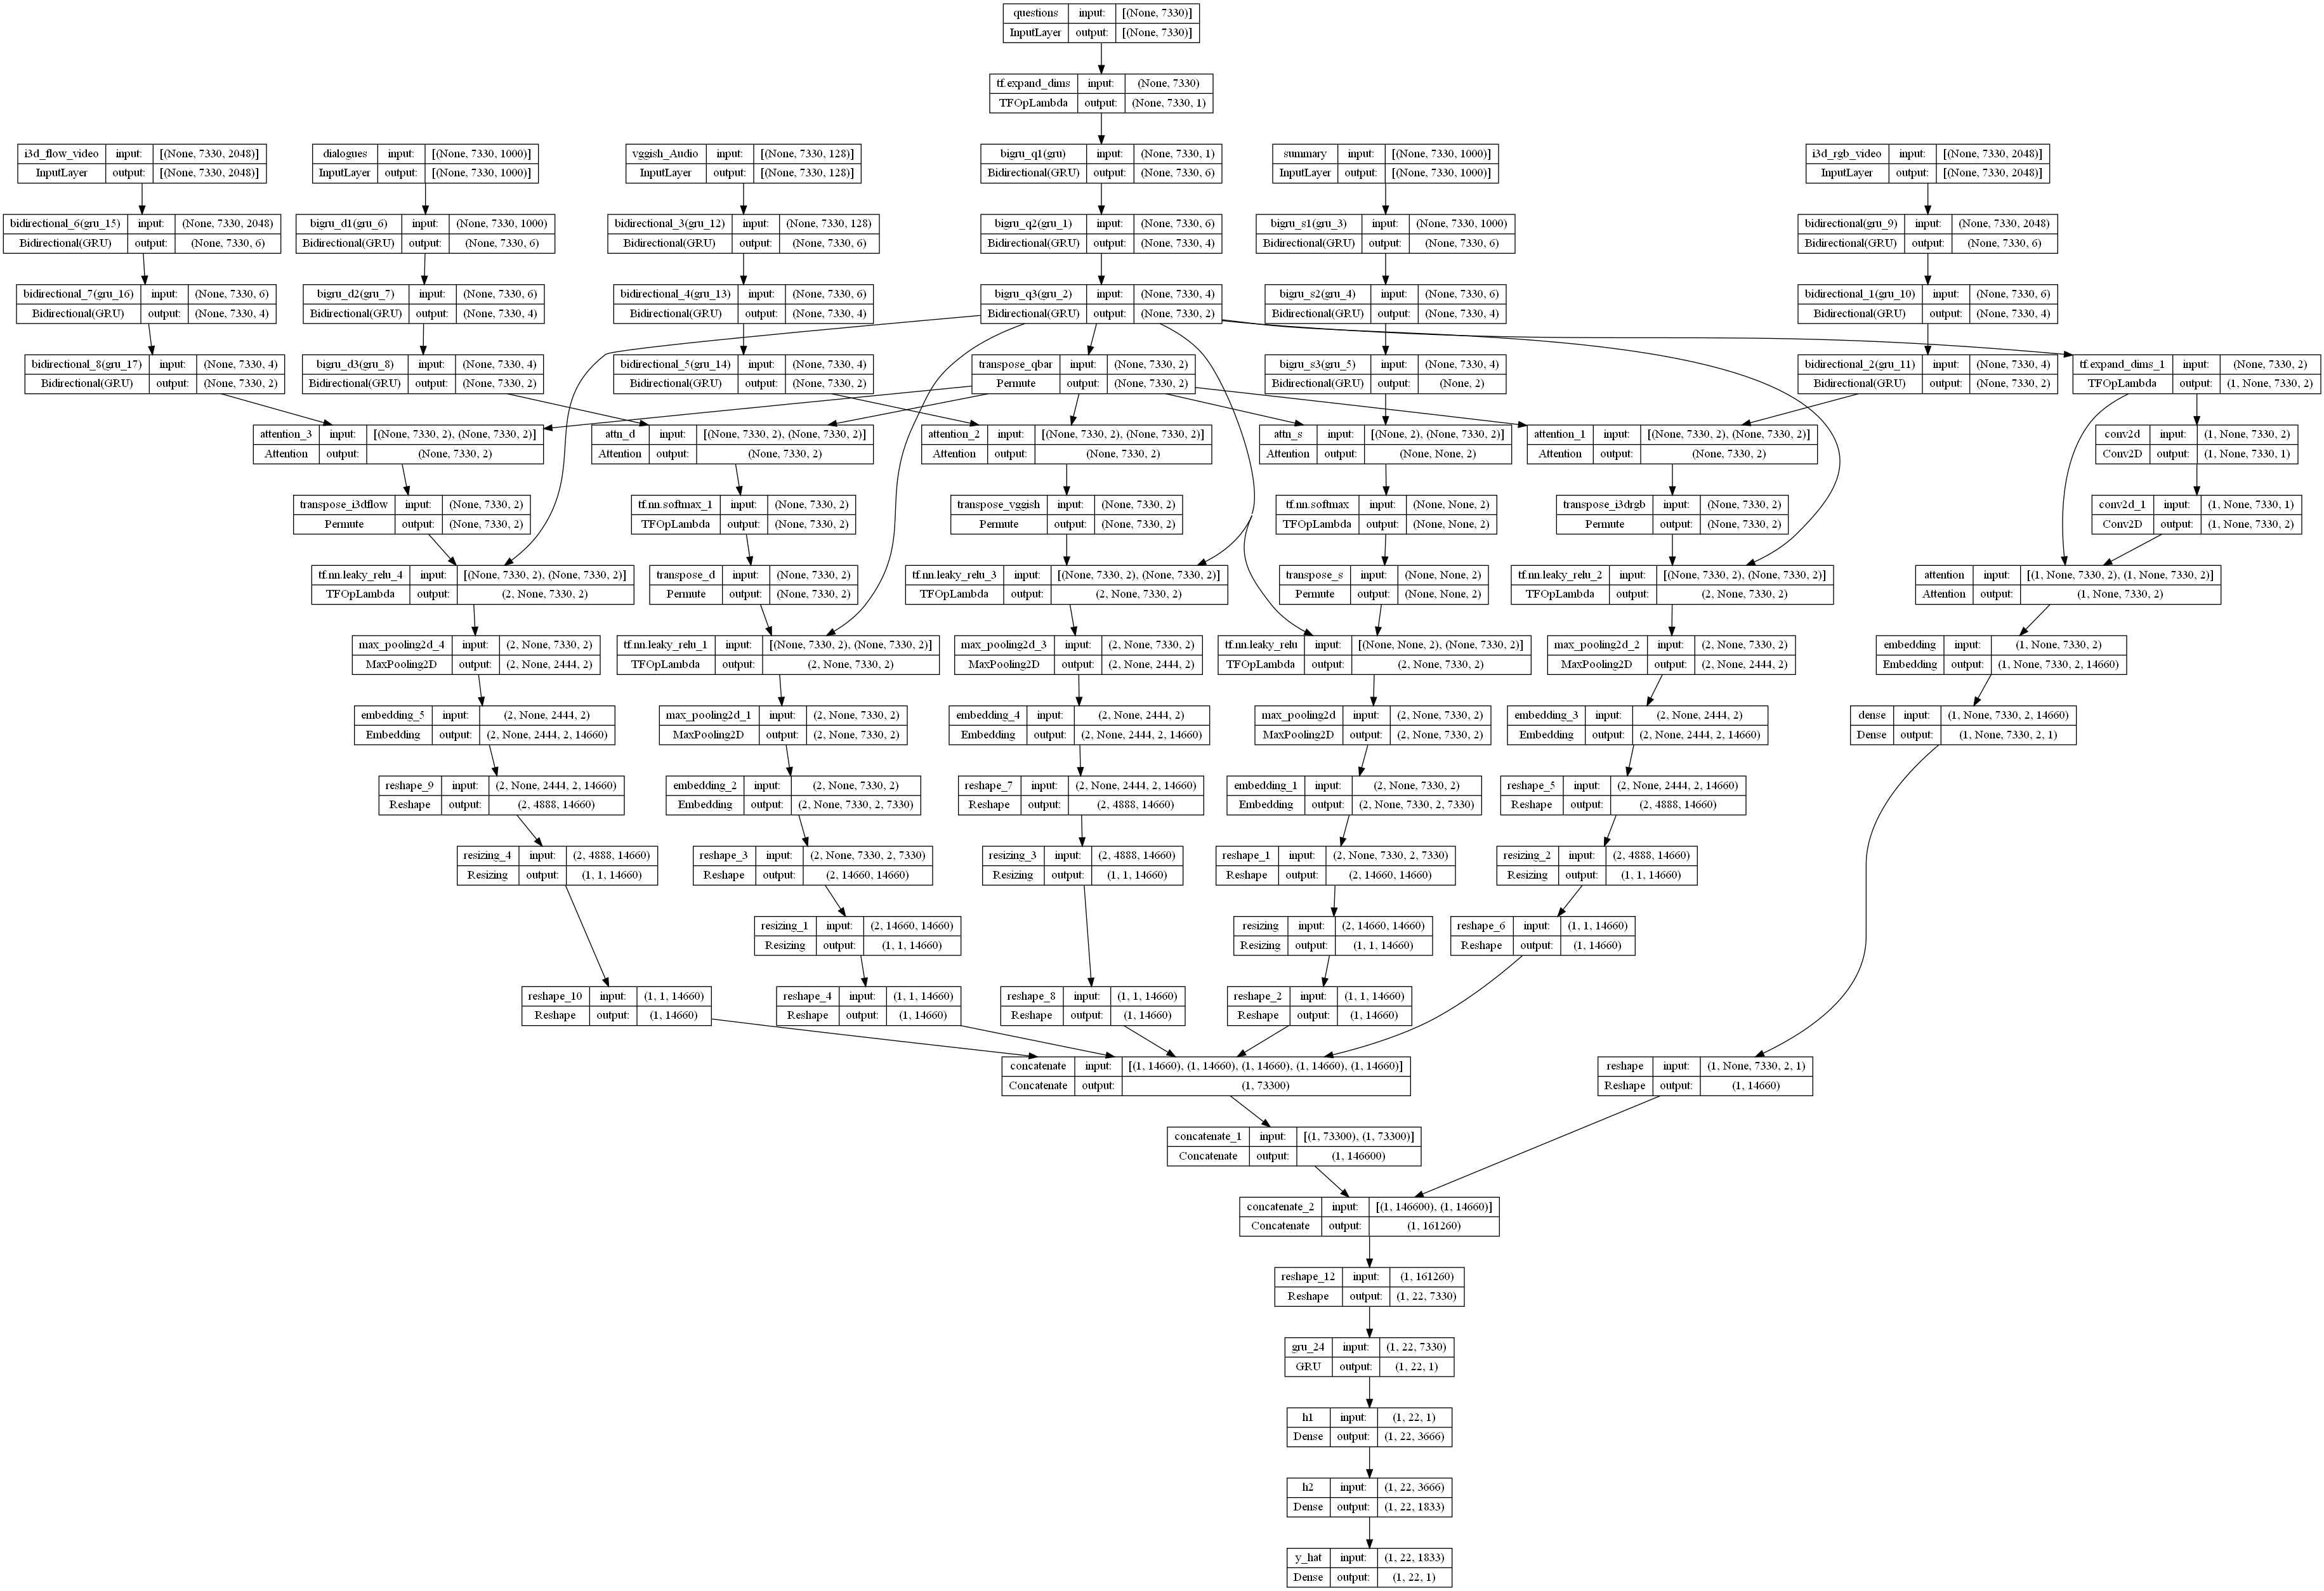

In [ ]:
#!pip install graphviz
#!pip install pydot
#import pydot, graphviz

tf.keras.utils.plot_model(model_final, show_shapes=True, show_layer_names=True, to_file='./model.png')
from IPython.display import Image
Image(filename='./model.png')


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
le = preprocessing.LabelEncoder()
y_target_q = le.fit_transform(x_train['question'])
questions = tf.convert_to_tensor(y_target_q)

y_target_s = le.fit_transform(x_train['summary'])
summary = tf.convert_to_tensor(y_target_s)
#summary = tf.convert_to_tensor(summary)

y_target_d = le.fit_transform(x_train['caption'])
dialogues = tf.convert_to_tensor(y_target_d)
#dialogues = tf.convert_to_tensor(dialogues)


Fit model

In [ ]:
model_final.compile(optimizer=optimizer, loss='mean_absolute_error', 
              metrics=['accuracy'])

In [ ]:
training = model_final.fit(x=[questions,summary,dialogues,i3d_flow,i3d_rgb,vggish], y=answers, batch_size=32, epochs=100, shuffle=True, verbose=0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
vggish_full = tf.convert_to_tensor(vggish_full)
i3d_rgb = tf.convert_to_tensor(i3d_rgb)
#i3d_flow = tf.convert_to_tensor(i3d_flow)
dialogues = tf.convert_to_tensor(dialogues)
summary = tf.convert_to_tensor(summary)
questions = tf.convert_to_tensor(questions)
answers = tf.convert_to_tensor(answers)

In [ ]:
i3d_flow

array([array([[0.10737336, 0.        , 0.01086632, ..., 0.01382594, 0.01350603,
               0.        ],
              [0.14448591, 0.        , 0.00865465, ..., 0.03589866, 0.03097124,
               0.        ],
              [0.21619542, 0.00025097, 0.        , ..., 0.06320382, 0.15634394,
               0.        ],
              ...,
              [0.2145218 , 0.00273727, 0.0200429 , ..., 0.00618446, 0.03615896,
               0.        ],
              [0.14667583, 0.        , 0.01062533, ..., 0.04975802, 0.01262555,
               0.        ],
              [0.1357576 , 0.00932428, 0.00893406, ..., 0.03069305, 0.00308408,
               0.        ]])                                                   ,
       array([[0.12168607, 0.20364557, 0.00853349, ..., 0.09807272, 0.        ,
               0.00789456],
              [0.04184553, 0.16445331, 0.04433951, ..., 0.09786613, 0.0016421 ,
               0.        ],
              [0.05092878, 0.17668726, 0.13718162, ..., 0.017331

In [ ]:
#x11 = tf.convert_to_tensor(x11)
i3d_rgb

<tf.Tensor: shape=(39392, 49, 512), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.8357845 , ..., 1.0963383 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.20251411, ..., 0.        ,
         0.        , 0.15283173],
        [0.40371868, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.08540872, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 1.4465597 , 0.08390293, ..., 

In [ ]:
x11 = i3d_flow.reshape([1968,1])
x11.shape

(1968, 1)

In [ ]:
pred_ans = model.predict()

In [ ]:
loss = tf.keras.losses.categorical_crossentropy(answers, pred_ans)